# GetAround - Analyse des Retards

## Objectif
Analyser les retards au checkout pour aider le Product Manager à répondre aux questions suivantes :

1. **Seuil** : Quelle doit être la durée minimale du délai entre deux locations ?
2. **Portée** : Faut-il activer cette fonctionnalité pour toutes les voitures ou uniquement pour les voitures Connect ?
3. **Impact revenu** : Quelle part des revenus serait potentiellement affectée par cette fonctionnalité ?
4. **Locations affectées** : Combien de locations seraient concernées en fonction du seuil et de la portée ?
5. **Fréquence des retards** : À quelle fréquence les conducteurs sont-ils en retard ? Quel impact sur le conducteur suivant ?
6. **Cas résolus** : Combien de cas problématiques seront résolus selon le seuil et la portée choisis ?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Chargement et exploration des données

In [3]:
df = pd.read_excel('get_around_delay_analysis.xlsx')
df.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


In [4]:
df.shape

(21310, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rental_id                                   21310 non-null  int64  
 1   car_id                                      21310 non-null  int64  
 2   checkin_type                                21310 non-null  object 
 3   state                                       21310 non-null  object 
 4   delay_at_checkout_in_minutes                16346 non-null  float64
 5   previous_ended_rental_id                    1841 non-null   float64
 6   time_delta_with_previous_rental_in_minutes  1841 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


In [6]:
df.describe()

,rental_id,car_id,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
count,21310.000000,21310.000000,16346.000000,1841.000000,1841.000000
mean,549712.880338,350030.603426,59.701517,550127.411733,279.288430
std,13863.446964,58206.249765,1002.561635,13184.023111,254.594486
min,504806.000000,159250.000000,-22433.000000,505628.000000,0.000000
25%,540613.250000,317639.000000,-36.000000,540896.000000,60.000000
50%,550350.000000,368717.000000,9.000000,550567.000000,180.000000
75%,560468.500000,394928.000000,67.000000,560823.000000,540.000000
max,576401.000000,417675.000000,71084.000000,575053.000000,720.000000


In [7]:
# Valeurs manquantes
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
pd.DataFrame({'missing': missing, 'pct': missing_pct}).round(1)

,missing,pct
rental_id,0,0.0
car_id,0,0.0
checkin_type,0,0.0
state,0,0.0
delay_at_checkout_in_minutes,4964,23.3
previous_ended_rental_id,19469,91.4
time_delta_with_previous_rental_in_minutes,19469,91.4


## Analyse des variables catégorielles

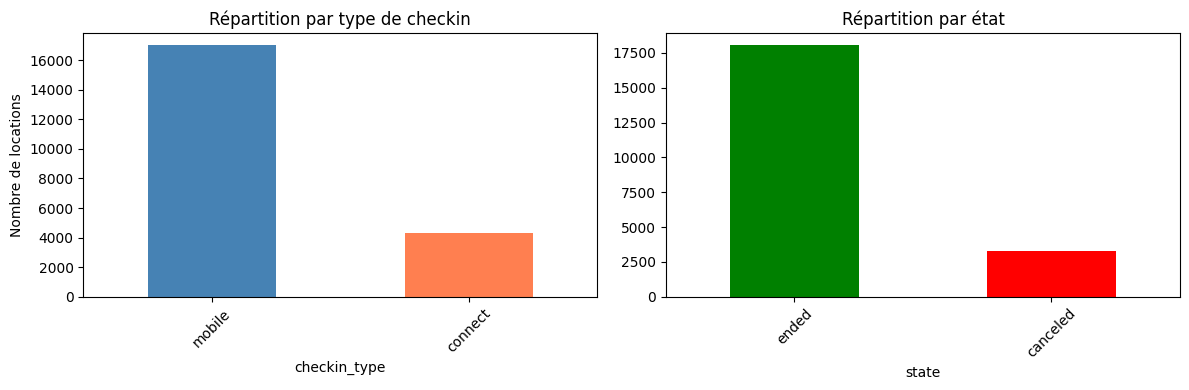

Checkin type:
checkin_type
mobile     79.8
connect    20.2
Name: proportion, dtype: float64

State:
state
ended       84.7
canceled    15.3
Name: proportion, dtype: float64


In [8]:
fig, axes = plt.subplots(1,2, figsize=(12, 4))

# Checkin type
df['checkin_type'].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Répartition par type de checkin')
axes[0].set_ylabel('Nombre de locations')

# State
df['state'].value_counts().plot(kind='bar', ax=axes[1], color=['green', 'red'])
axes[1].set_title('Répartition par état')

axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Checkin type:")
print(df['checkin_type'].value_counts(normalize=True).round(3) *100)
print("\nState:")
print(df['state'].value_counts(normalize=True).round(3) * 100)

## Question 5 : À quelle fréquence les conducteurs sont-ils en retard ?

In [11]:
# Focus sur les locations terminées avec delay enregistré
ended = df[df['state'] == 'ended'].copy()
with_delay = ended[ended['delay_at_checkout_in_minutes'].notna()].copy()

print(f"Locations terminées: {len(ended)}")
print(f"Avec delay enregistré: {len(with_delay)}")

Locations terminées: 18045
Avec delay enregistré: 16345


#### Note sur les outliers

Les données contiennent des valeurs extrêmes :
- **Max retard** : 71,084 min (~49 jours)
- **Max avance** : -22,433 min (~15 jours)
- 188 locations avec retard > 24h

Ces outliers sont probablement des erreurs de saisie ou des cas exceptionnels.

**Décision** : Je ne filtre pas ces outliers car :
1. Mon analyse utilise des pourcentages et des seuils (30-240 min), pas des moyennes
2. Les outliers extrêmes n'impactent pas les décisions sur les seuils
3. 99% des données sont entre -853 min (P1) et +1491 min (P99)

In [12]:
# Classification: en retard vs à l'heure
with_delay['is_late'] = with_delay['delay_at_checkout_in_minutes'] > 0

late_count = with_delay['is_late'].sum()
late_pct = 100 * late_count /len(with_delay)

print(f"En retard: {late_count} ({late_pct:.1f}%)")
print(f"A l'heure ou en avance: {len(with_delay) - late_count} ({100 - late_pct:.1f}%)")

En retard: 9404 (57.5%)
A l'heure ou en avance: 6941 (42.5%)


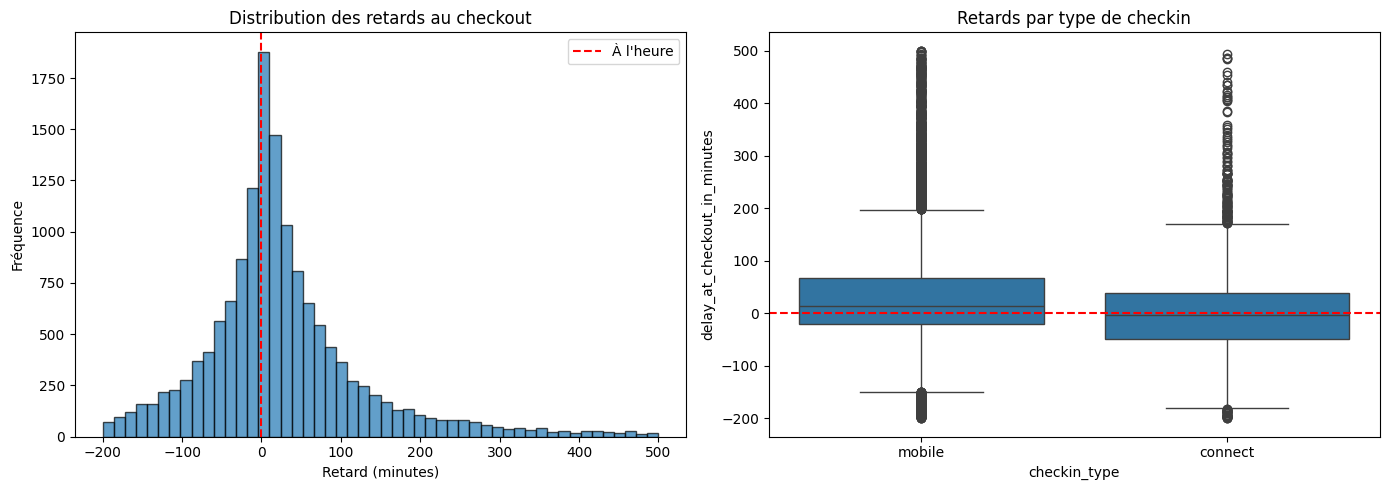

In [13]:
# Distribution des retards (filtré pour lisibilité)
delay_filtered = with_delay[
    (with_delay['delay_at_checkout_in_minutes'] >= -200) &
    (with_delay['delay_at_checkout_in_minutes'] <= 500)
]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(delay_filtered['delay_at_checkout_in_minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', label='À l\'heure')
axes[0].set_xlabel('Retard (minutes)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des retards au checkout')
axes[0].legend()

# Boxplot par type de checkin
sns.boxplot(data=delay_filtered, x='checkin_type', y='delay_at_checkout_in_minutes', ax=axes[1])
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_title('Retards par type de checkin')

plt.tight_layout()
plt.show()

Histogramme : la majorité des retours se font proche de l'heure prévue, mais avec une tendance aux retards.

Boxplot : connect est plus ponctuel (médiane ~0 min) que Mobile (médiane ~20 min), ce qui justifie de tester le seuil d'abord sur Connect.

In [15]:
# Taux de retard par type de checkin
late_by_type = with_delay.groupby('checkin_type')['is_late'].agg(['sum', 'count', 'mean'])
late_by_type.columns = ['nb_late', 'total', 'pct_late']
late_by_type['pct_late'] = (late_by_type['pct_late'] * 100).round(1)
late_by_type


,nb_late,total,pct_late
checkin_type,,,
connect,1459,3402,42.9
mobile,7945,12943,61.4


In [16]:
# Distribution cumulative des retards
thresholds = [0, 15, 30, 60, 90, 120, 180, 240, 300, 360]

results = []
for t in thresholds:
    count = (with_delay['delay_at_checkout_in_minutes'] > t).sum()
    pct = 100 * count / len(with_delay)
    results.append({'threshold_min': t, 'nb_late': count, 'pct_late': round(pct, 1)})

threshold_df = pd.DataFrame(results)
threshold_df

,threshold_min,nb_late,pct_late
0,0,9404,57.5
1,15,7416,45.4
2,30,6078,37.2
3,60,4386,26.8
4,90,3257,19.9
5,120,2553,15.6
6,180,1756,10.7
7,240,1334,8.2
8,300,1049,6.4
9,360,885,5.4


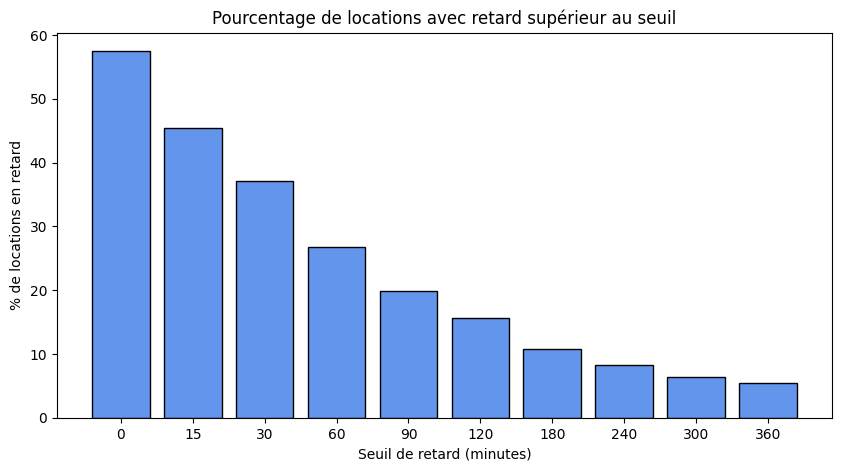

In [23]:
# Visualisation
plt.figure(figsize=(10, 5))
plt.bar(threshold_df['threshold_min'].astype(str), threshold_df['pct_late'], color='cornflowerblue', edgecolor='black')
plt.xlabel('Seuil de retard (minutes)')
plt.ylabel('% de locations en retard')
plt.title('Pourcentage de locations avec retard supérieur au seuil')
plt.show()

Ce graphique montre le pourcentage de locations en retard selon différents seuils : 57% ont un retard > 0 min, mais seulement 27% dépassent 60 min et 11% dépassent 180 min.

Plus le seuil augmente, moins il y a de locations concernées.

### Réponse question 5a : Fréquence des retards

- **57.5%** des locations se terminent en retard
- **Mobile** : 61.4% de retards vs **Connect** : 42.9%
- Retards significatifs : 27% > 1h, 16% > 2h, 11% > 3h
- La médiane est à ~9 min de retard

## Question 5 (suite) : Quel impact sur le conducteur suivant ?

In [24]:
# Locations avec une location précédente
consecutive = df[df['previous_ended_rental_id'].notna()].copy()
print(f"Locations consécutives: {len(consecutive)} ({100*len(consecutive)/len(df):.1f}%)")

print("\nPar type de checkin:")
print(consecutive['checkin_type'].value_counts())

print("\nPar état:")
print(consecutive['state'].value_counts())


Locations consécutives: 1841 (8.6%)

Par type de checkin:
checkin_type
mobile     1028
connect     813
Name: count, dtype: int64

Par état:
state
ended       1612
canceled     229
Name: count, dtype: int64


In [25]:
# Joindre le delay de la location précédente
prev_delays = df[['rental_id', 'delay_at_checkout_in_minutes']].copy()
prev_delays.columns = ['previous_ended_rental_id', 'previous_delay']

consecutive = consecutive.merge(prev_delays, on='previous_ended_rental_id', how='left')

# Garder seulement les lignes avec toutes les infos
with_data = consecutive[
    consecutive['previous_delay'].notna() &
    consecutive['time_delta_with_previous_rental_in_minutes'].notna()
].copy()

print(f"Locations consécutives avec données complètes: {len(with_data)}")


Locations consécutives avec données complètes: 1729


In [26]:
# Cas problématiques: retard précédent > time_delta
with_data['is_impacted'] = with_data['previous_delay'] > with_data['time_delta_with_previous_rental_in_minutes']

impacted_count = with_data['is_impacted'].sum()
impacted_pct = 100 * impacted_count / len(with_data)

print(f"Locations impactées par un retard précédent: {impacted_count} ({impacted_pct:.1f}%)")


Locations impactées par un retard précédent: 218 (12.6%)


In [27]:
# Impact par type de checkin
impact_by_type = with_data.groupby('checkin_type')['is_impacted'].agg(['sum', 'count', 'mean'])
impact_by_type.columns = ['nb_impacted', 'total', 'pct_impacted']
impact_by_type['pct_impacted'] = (impact_by_type['pct_impacted'] * 100).round(1)
impact_by_type


,nb_impacted,total,pct_impacted
checkin_type,,,
connect,69,791,8.7
mobile,149,938,15.9


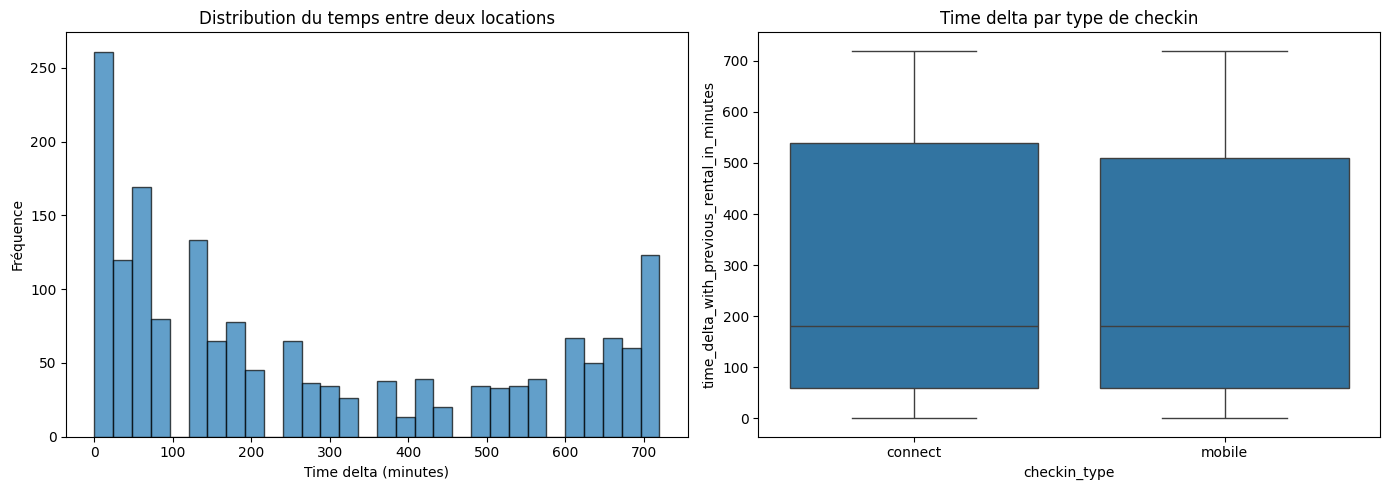

In [28]:
# Distribution du time_delta
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(with_data['time_delta_with_previous_rental_in_minutes'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Time delta (minutes)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution du temps entre deux locations')

sns.boxplot(data=with_data, x='checkin_type', y='time_delta_with_previous_rental_in_minutes', ax=axes[1])
axes[1].set_title('Time delta par type de checkin')

plt.tight_layout()
plt.show()


Histogramme : le temps entre deux locations est souvent court (pic à 0-100 min), avec un second pic à 720 min (12h), correspondant probablement aux créneaux demi-journée.

Boxplot : Connect et Mobile ont des distributions similaires (médiane ~180 min), mais Connect a légèrement moins de variabilité.

### Réponse question 5b : Impact sur le conducteur suivant

- **1,729** locations consécutives analysables (8.6% du total)
- **218 cas problématiques** (12.6%) où le retard impacte réellement le conducteur suivant
- Impact par type : **Mobile 15.9%** vs **Connect 8.7%**
- les conducteurs Connect sont moins impactés par les retards

## Questions 4 & 6 : Locations affectées et cas résolus selon seuil/portée

In [29]:
def simulate_threshold(data, threshold):
    """Simule l'impact d'un seuil donné."""
    problematic = data[data['previous_delay'] > data['time_delta_with_previous_rental_in_minutes']]

    # Cas résolus: auraient été bloqués par le seuil
    resolved = data[
        (data['time_delta_with_previous_rental_in_minutes'] < threshold) &
        (data['previous_delay'] > data['time_delta_with_previous_rental_in_minutes'])
    ]

    # Locations bloquées par le seuil
    blocked = data[data['time_delta_with_previous_rental_in_minutes'] < threshold]

    return {
        'threshold': threshold,
        'problematic': len(problematic),
        'resolved': len(resolved),
        'pct_resolved': 100 * len(resolved) / len(problematic) if len(problematic) > 0 else 0,
        'blocked': len(blocked),
        'pct_blocked': 100 * len(blocked) / len(data)
    }


In [30]:
# Simulation pour différents seuils - SCOPE: ALL
thresholds = [0, 15, 30, 60, 90, 120, 180, 240, 300, 360]

results_all = [simulate_threshold(with_data, t) for t in thresholds]
df_results_all = pd.DataFrame(results_all)
df_results_all.round(1)


,threshold,problematic,resolved,pct_resolved,blocked,pct_blocked
0,0,218,0,0.0,0,0.0
1,15,218,116,53.2,261,15.1
2,30,218,116,53.2,261,15.1
3,60,218,146,67.0,381,22.0
4,90,218,172,78.9,550,31.8
5,120,218,180,82.6,630,36.4
6,180,218,196,89.9,828,47.9
7,240,218,202,92.7,951,55.0
8,300,218,207,95.0,1052,60.8
9,360,218,208,95.4,1112,64.3


In [31]:
# Simulation - SCOPE: CONNECT ONLY
connect_data = with_data[with_data['checkin_type'] == 'connect']

results_connect = [simulate_threshold(connect_data, t) for t in thresholds]
df_results_connect = pd.DataFrame(results_connect)
df_results_connect.round(1)


,threshold,problematic,resolved,pct_resolved,blocked,pct_blocked
0,0,69,0,0.0,0,0.0
1,15,69,40,58.0,127,16.1
2,30,69,40,58.0,127,16.1
3,60,69,48,69.6,177,22.4
4,90,69,56,81.2,252,31.9
5,120,69,59,85.5,287,36.3
6,180,69,64,92.8,363,45.9
7,240,69,66,95.7,421,53.2
8,300,69,67,97.1,468,59.2
9,360,69,67,97.1,489,61.8


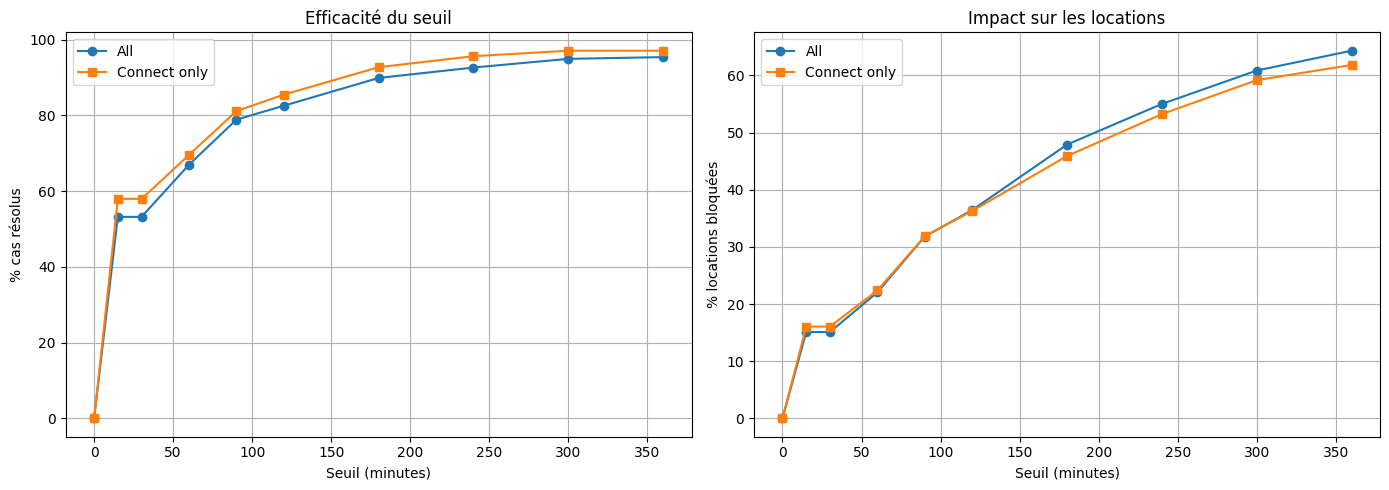

In [32]:
# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# % de cas résolus
axes[0].plot(df_results_all['threshold'], df_results_all['pct_resolved'], marker='o', label='All')
axes[0].plot(df_results_connect['threshold'], df_results_connect['pct_resolved'], marker='s', label='Connect only')
axes[0].set_xlabel('Seuil (minutes)')
axes[0].set_ylabel('% cas résolus')
axes[0].set_title('Efficacité du seuil')
axes[0].legend()
axes[0].grid(True)

# % de locations bloquées
axes[1].plot(df_results_all['threshold'], df_results_all['pct_blocked'], marker='o', label='All')
axes[1].plot(df_results_connect['threshold'], df_results_connect['pct_blocked'], marker='s', label='Connect only')
axes[1].set_xlabel('Seuil (minutes)')
axes[1].set_ylabel('% locations bloquées')
axes[1].set_title('Impact sur les locations')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Efficacité (gauche) : plus le seuil augmente, plus on résout de cas problématiques (83% à 120 min, 95% à 300 min), avec Connect légèrement plus efficace.

Impact (droite) : le coût augmente aussi avec le seuil (36% de locations bloquées à 120 min, 65% à 360 min), les deux scopes ayant un impact similaire.

### Réponse question 4 : Locations affectées selon seuil/portée

Un seuil de 120 minutes bloquerait environ 36% des locations consécutives (630 pour All, 287 pour Connect), tandis qu'un seuil de 60 minutes n'en bloquerait que 22%.

### Réponse question 6 : Cas problématiques résolus

Un seuil de 120 minutes résoudrait 83-86% des cas problématiques, contre seulement 53-58% pour un seuil de 30 minutes. Connect performe légèrement mieux à chaque seuil.

## Question 3 : Quelle part des revenus serait affectée ?

In [33]:
total_ended = len(df[df['state'] == 'ended'])
connect_ended = len(df[(df['state'] == 'ended') & (df['checkin_type'] == 'connect')])

print(f"Total locations terminées: {total_ended}")
print(f"Locations Connect terminées: {connect_ended}")

print("\n--- Impact sur revenu (approximation) ---")
print("Hypothèse: location bloquée = perte de revenu\n")

for t in [30, 60, 120, 180]:
    blocked_all = len(with_data[with_data['time_delta_with_previous_rental_in_minutes'] < t])
    blocked_connect = len(connect_data[connect_data['time_delta_with_previous_rental_in_minutes'] < t])

    print(f"Seuil {t} min:")
    print(f"  - All: {blocked_all} locations bloquées ({100*blocked_all/total_ended:.2f}% du total)")
    print(f"  - Connect: {blocked_connect} locations bloquées ({100*blocked_connect/connect_ended:.2f}% du total Connect)")


Total locations terminées: 18045
Locations Connect terminées: 3509

--- Impact sur revenu (approximation) ---
Hypothèse: location bloquée = perte de revenu

Seuil 30 min:
  - All: 261 locations bloquées (1.45% du total)
  - Connect: 127 locations bloquées (3.62% du total Connect)
Seuil 60 min:
  - All: 381 locations bloquées (2.11% du total)
  - Connect: 177 locations bloquées (5.04% du total Connect)
Seuil 120 min:
  - All: 630 locations bloquées (3.49% du total)
  - Connect: 287 locations bloquées (8.18% du total Connect)
Seuil 180 min:
  - All: 828 locations bloquées (4.59% du total)
  - Connect: 363 locations bloquées (10.34% du total Connect)


### Réponse question 3 : Impact sur les revenus

Impact global limité : avec un seuil de 120 min, seulement 3.5% du total des locations seraient bloquées (630 sur 18,045), représentant une perte de revenu modérée.

Connect plus impacté en pourcentage : le même seuil bloquerait 8.2% des locations Connect (287 sur 3,509), mais ce volume reste faible en valeur absolue car Connect ne représente que 20% du parc.

## Questions 1 & 2 : Recommandations seuil et portée

In [34]:
# Tableau récapitulatif
summary = pd.DataFrame({
    'Seuil (min)': [30, 60, 120, 180],
    'Cas résolus (All)': ['53%', '67%', '83%', '90%'],
    'Locations bloquées (All)': ['15%', '22%', '36%', '48%'],
    'Cas résolus (Connect)': ['58%', '70%', '86%', '93%'],
    'Locations bloquées (Connect)': ['16%', '22%', '36%', '46%']
})
summary


,Seuil (min),Cas résolus (All),Locations bloquées (All),Cas résolus (Connect),Locations bloquées (Connect)
0,30,53%,15%,58%,16%
1,60,67%,22%,70%,22%
2,120,83%,36%,86%,36%
3,180,90%,48%,93%,46%


### Recommandations

**Seuil recommandé: 120 minutes**
- résout ~83% des cas problématiques
- impact modéré sur les locations (~36% des consécutives, ~3.5% du total)
- bon compromis efficacité/revenu

**Portée recommandé: Connect uniquement (dans un premier temps)**
- taux de retard plus faible (43% vs 61% pour Mobile)
- impact limité car Connect = 20% des locations
- permet de tester la feature avant déploiement global


### Réponse question 1 : seuil recommandé = **120 minutes**
### Réponse question 2 : portée recommandée = **Connect uniquement** (phase pilote)